In [1]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-63f29759-7777-2776-6218-730e7210ccb7)


In [1]:
#Colab資料夾設定方法
#!pip install google.colab #如未安裝取消註解後執行
import os

from google.colab import drive
drive.mount('/content/drive')

##出現提示欄進行授權

Mounted at /content/drive


In [2]:
os.chdir('/content/drive/MyDrive/SRFlow')
os.listdir()

['README.md',
 'requirements.txt',
 'run_jupyter.sh',
 'setup.sh',
 '.gitignore',
 'LICENSE',
 'SRFlow_demo_(file_200004).jpynb',
 'SRFlow_demo_(file_200263).jpynb',
 'SRFlow_demo_(file_200001).jpynb',
 'SRFlow_demo_(file_200355).jpynb',
 'SRFlow_demo_(file_162844).jpynb',
 'SRFlow_demo_(file_162861).jpynb',
 'SRFlow_demo_(file_202503).jpynb',
 'SRFlow_demo_(file_202159).jpynb',
 'SRFlow_demo_(insets_x4).jpynb',
 'SRFlow.ipynb 的副本',
 'demo_on_pretrained.ipynb',
 'SRFlow_demo_(file_200003).jpynb',
 'SRFlow_demo_(gray).jpynb',
 'SRFlow_train_celebA_tony.ipynb 的副本',
 'SRFlow_demo_(insets_x8).jpynb',
 'SRFlow_demo_(file_DIV2k_0892).jpynb',
 'SRFlow_(CelebA_200355)_Bicubic_x8_LR_PSNR_SSIM(Tony).jpynb',
 'SRFlow_(DIV2k_0892)_Bicubic_x8_LR_PSNR_SSIM(Tony).jpynb',
 'SRFlow_(CelebA_200003)_Bicubic_x8_LR_PSNR_SSIM(Tony).jpynb',
 'SRFlow_(DIV2k_0846)_Bicubic_x8_LR_PSNR_SSIM(Tony).jpynb',
 'SRFlow_(Gray)_Bicubic_x8_LR_PSNR_SSIM(Tony).jpynb 的副本',
 'SRFlow_(Set14_011)_Bicubic_x8_LR_PSNR_SSIM(Tony).j

In [3]:
!pip3 install lpips

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 2.3 MB/s 


In [4]:
os.chdir('/content/drive/MyDrive/SRFlow/code')
os.listdir()

['imresize.py',
 'Measure.py',
 'train.py',
 'prepare_data.py',
 'demo_on_pretrained.ipynb',
 'options',
 'utils',
 '__pycache__',
 'models',
 'data',
 'confs',
 'img_align_celeba',
 'sr_test.py',
 'dummy_image.png',
 'sr_test_avg_time.py']

In [5]:
import sys
print(sys.executable) 

/usr/bin/python3


In [6]:
import natsort, glob, pickle, torch
from collections import OrderedDict
import numpy as np
import os

import options.options as option
from models import create_model
from imresize import imresize

import Measure

def find_files(wildcard): return natsort.natsorted(glob.glob(wildcard, recursive=True))

from PIL import Image
def imshow(array):
    display(Image.fromarray(array))


from sr_test import load_model, fiFindByWildcard, imread

def pickleRead(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [7]:
# Convert to tensor
def t(array): return torch.Tensor(np.expand_dims(array.transpose([2, 0, 1]), axis=0).astype(np.float32)) / 255

# convert to image
def rgb(t): return (np.clip((t[0] if len(t.shape) == 4 else t).detach().cpu().numpy().transpose([1, 2, 0]), 0, 1) * 255).astype(np.uint8)

In [8]:
#conf_path = './confs/SRFlow_CelebA_8X.yml'
conf_path = './confs/SRFlow_DIV2K_8X.yml'

In [9]:
model, opt = load_model(conf_path)

OrderedDict([('manual_seed', 10), ('lr_G', 0.0005), ('weight_decay_G', 0), ('beta1', 0.9), ('beta2', 0.99), ('lr_scheme', 'MultiStepLR'), ('warmup_iter', -1), ('lr_steps_rel', [0.5, 0.75, 0.9, 0.95]), ('lr_gamma', 0.5), ('niter', 200000), ('val_freq', 40000), ('lr_steps', [100000, 150000, 180000, 190000])])


In [10]:
lq_paths = fiFindByWildcard(os.path.join(opt['dataroot_LR'], '*.png'))
gt_paths = fiFindByWildcard(os.path.join(opt['dataroot_GT'], '*.png'))
print(lq_paths, gt_paths) # For CelebA we have just 1

['../datasets/tony/div2k-x8/0846_lr_200x200.png', '../datasets/tony/div2k-x8/0892_lr_200x200.png'] ['../datasets/tony/div2k-gt/0846_hr_1600x1600.png', '../datasets/tony/div2k-gt/0892_hr_1600x1600.png']


In [11]:
lqs = [imread(p) for p in lq_paths]
gts = [imread(p) for p in gt_paths]

First LR image


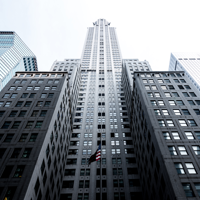

(200, 200, 3)


In [12]:
print("First LR image")
imshow(lqs[0])
print(lqs[0].shape)

In [13]:
print("First HR image")
imshow(gts[0])
print(gts[0].shape)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
measure = Measure.Measure()

In [ ]:
lq = lqs[0]
gt = gts[0]

for temperature in np.linspace(0, 1, num=11):
    # Sample a super-resolution for a low-resolution image
    sr = rgb(model.get_sr(lq=t(lq), heat=temperature))
    imshow(sr)
    psnr, ssim, lpips = measure.measure(sr, gt)
    print('Temperature: {:0.2f} - PSNR: {:0.1f}, SSIM: {:0.1f}, LPIPS: {:0.2f}\n\n'.format(temperature, psnr, ssim, lpips))

In [18]:
# >>>>>>>>> add by tony >>>>>>>>>>
from torch.autograd import Variable
from torchvision.transforms import ToTensor
from PIL import Image

dummy_image = Image.open('dummy_image.png')  # add by tony for time
with torch.no_grad():
    dummy_image = Variable(ToTensor()(dummy_image)).unsqueeze(0)  # add by tony for time
    dummy_image = dummy_image.cuda()  # add by tony for time

import time
from torch.backends import cudnn

cudnn.benchmark = True
print('warm up ...\n')
with torch.no_grad():
    for _ in range(10):
      _ = model.get_sr(lq=dummy_image, heat=0.8)
 
torch.cuda.synchronize()
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
total_elapsed_time = 0
print('start testing ...\n')
with torch.no_grad():
    for _ in range(100):
      starter.record()
      _ = model.get_sr(lq=dummy_image, heat=0.8)
      ender.record()
      torch.cuda.synchronize()
      elapsed = starter.elapsed_time(ender)
      total_elapsed_time = total_elapsed_time + elapsed
      print('cost' + str(elapsed) + 's')

avg_elapsed = total_elapsed_time/100;
print('Avg. cost:' + str(avg_elapsed) + 's')
torch.cuda.synchronize()

warm up ...

start testing ...

cost901.7221069335938s
cost909.5731201171875s
cost905.7402954101562s
cost909.2260131835938s
cost911.4542236328125s
cost908.526611328125s
cost914.5077514648438s
cost906.2379760742188s
cost908.3883666992188s
cost904.5565185546875s
cost909.0057983398438s
cost916.3120727539062s
cost912.4342041015625s
cost905.533447265625s
cost913.70703125s
cost924.3719482421875s
cost914.94091796875s
cost909.633544921875s
cost905.9625244140625s
cost907.6039428710938s
cost909.0580444335938s
cost916.4503173828125s
cost907.5742797851562s
cost916.9500122070312s
cost910.6749267578125s
cost912.110595703125s
cost922.1744384765625s
cost921.6962280273438s
cost918.6795654296875s
cost915.7427368164062s
cost917.0616455078125s
cost915.18359375s
cost932.73193359375s
cost919.1177978515625s
cost911.3640747070312s
cost909.7512817382812s
cost910.4967651367188s
cost911.5074462890625s
cost923.9326782226562s
cost907.71044921875s
cost909.4779052734375s
cost913.9783935546875s
cost911.5003051757812s

In [15]:
import time
# Sample a super-resolution for a low-resolution image
lq = lqs[0]
gt = gts[0]

lr_t = t(lq)

starter.record()
sr_tmp = model.get_sr(lq=lr_t, heat=0.8)
ender.record()
torch.cuda.synchronize()
elapsed = starter.elapsed_time(ender)
total_elapsed_time = total_elapsed_time + elapsed

print('cost' + str(elapsed) + 's')

sr = rgb(sr_tmp)
#sr = rgb(model.get_sr(lq=t(lq), heat=0.9))
imshow(sr)
#print(type(sr))
#print(type(gt))
psnr, ssim, lpips = measure.measure(sr, gt)
print('Temperature: {:0.2f} - PSNR: {:0.1f}, SSIM: {:0.1f}, LPIPS: {:0.2f}\n\n'.format(0.9, psnr, ssim, lpips))

Output hidden; open in https://colab.research.google.com to view.